# Load Dataset

This notebook assumes you downloaded the folder and extracted it in the same folder your notebook is in.

### Importing Libraries

In [22]:
import os
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import v2, functional
from torchvision import datasets
from torch.utils.data import *
from torch import nn, F

import numpy as np
import skimage.transform as sk_tfm
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

import random

### Cleaning File Structure

A small sneak at our data and you'll find that the we have 3 folders `day`, `night_2nd_round`, `night_3rd_round`. The night folders all have their images in other folders themselves.

In [11]:
folders_2nd = os.listdir(os.path.join("day-night images","night_2nd_round"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'day-night images\\night_2nd_round'

We should first change the file structure so that it meets what the pytorch `Datasets` expect.

In [9]:
new_dest = "day_night_clean"
night_dest="night"
try:
    os.mkdir(new_dest)
    os.chdir(new_dest)
    os.mkdir(night_dest)
    os.chdir("..")
    
except OSError as error:
    print(error)

print(os.getcwd())


[WinError 183] Cannot create a file when that file already exists: 'day_night_clean'
d:\TaletinoAI


In [10]:
for folder in folders_2nd:
    night_files=os.listdir(os.path.join("day-night images","night_2nd_round",folder))
    for file in night_files:
        try:
            source_path=os.path.join("day-night images","night_2nd_round",folder,file)
        except FileNotFoundError:
            print("Data already cleaned!")
            break
        dest_path=os.path.join(new_dest,night_dest,file)
        os.renames(source_path,dest_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'day-night images\\night_2nd_round\\folder_1'

Now that we've moved the images from `night_2nd_round` we have to do the same thing to `night_3rd_round` & `day`. I still keep a cakup of my files in another place on the disk, because I don't trust myself not to meess something up. Try to do the same, whenever you're working with data you got yourself.

In [12]:
folders_3rd = os.listdir(os.path.join("day-night images","night_3rd_round"))
print(folders_3rd)

['folder_103', 'folder_113', 'folder_115', 'folder_118', 'folder_122', 'folder_134', 'folder_136', 'folder_21', 'folder_22', 'folder_24', 'folder_31', 'folder_32', 'folder_48', 'folder_53', 'folder_58', 'folder_69', 'folder_74', 'folder_90', 'folder_93']


In [13]:
for folder in folders_3rd:
    night_files=os.listdir(os.path.join("day-night images","night_3rd_round",folder))
    for file in night_files:
        source_path=os.path.join("day-night images","night_3rd_round",folder,file)
        dest_path=os.path.join(new_dest,night_dest,file)
        os.renames(source_path,dest_path)

In [14]:
day_dest="day"

day_files=os.listdir(os.path.join("day-night images","day"))
for file in day_files:
    source_path=os.path.join("day-night images","day",file)
    dest_path=os.path.join(new_dest,day_dest,file)
    os.renames(source_path,dest_path)

Congrats, we've finished cleaning up our file structure.

# Visualizing Data

Our problem may be that out day images are so much more than the day images. Let's see.

In [3]:
day_images=os.listdir(os.path.join("day_night_clean","day"))
night_images=os.listdir(os.path.join("day_night_clean","night"))

print("Number of day images is:", len(day_images))
print("Number of night images is:", len(night_images))

Number of day images is: 250
Number of night images is: 5678


A naive solution is to take only a small subset of the night images. But I'll probably use f1-score as our accuracy of our model.

Text(0.5, 1.0, 'Day Image')

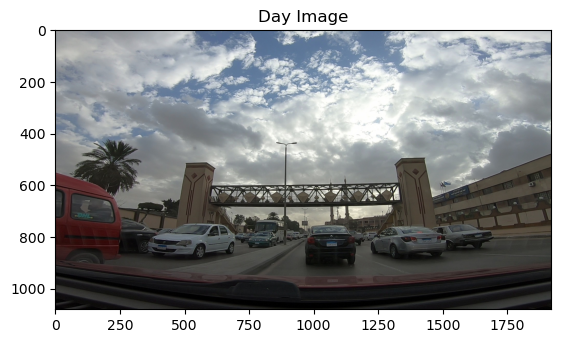

In [4]:
img=cv2.imread(os.path.join("day_night_clean","day",day_images[100]))
# remember that opencv loads data as BGR, change that to RGB to get ur image
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Day Image")

Those images are too big, so we'll have to put that in mind while pre-processing

In [5]:
transforms= v2.Compose([
    v2.RandomResizedCrop(size=(64,64)),
    v2.RandomHorizontalFlip(), #flipping image to its mirror shouldn't change our classification
    v2.ToImage(),  # this and the next line are the new ToTensor
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
dataset=datasets.ImageFolder(root='day_night_clean',transform=transforms)
dataloader=DataLoader(dataset, batch_size=32,shuffle=True)

# SVM Classifier

The SVM model will demand that we resize our images first and flatten it.

### Pre-processing for SVM

Here as I mentioned, we have a problem of our night data becoming too big. Here I'll use a naive implementation by downsampling data. But before we do that and take only the first 300 indices or something. We'll shuffle the paths in our list, because if we take a close look at the data we'll find that the data was taken by splitting frames of a video. So if we take the first 300 indices, we might endup with all of our night frames be from the same video. This can cause overfitting. We could've also skipped 3 images for example for each image we take from the night folders, but this can be don later.

##### Downsampling

In [27]:
classes=["day", "night"]
flat_imgs=[]
target=[]
for category in classes:
    cat_path=os.path.join(new_dest,category)
    cat_list=os.listdir(cat_path)
    random.shuffle(cat_list)

    i=0
    for img_file in cat_list:
        i+=1
        if (i==300): #take subset of night images
            break
        img_path=os.path.join(cat_path,img_file)
        img=cv2.imread(img_path)
        img=sk_tfm.resize(img,(120,120,3))
        flat_imgs.append(img.flatten())
        target.append(classes.index(category))

# change lists to np array
flat_imgs=np.array(flat_imgs)
target=np.array(target)
        
        
        

In [28]:
print(len(flat_imgs))

549


In [29]:
# convert to dataframe
svm_df=pd.DataFrame(flat_imgs) 
# add Target column
svm_df['Target']=target
svm_df.shape

(549, 43201)

As you can see, the `svm_df` dataframe has 43,201 columns corresponding to our flattened (120,120,3) image, equals 120*120*3=43,200 and one extra column for the target. To train our model, we'll have to split this dataframe into x and y. We'll use pandas `iloc`

In [30]:
x=svm_df.iloc[:,:-1]
y=svm_df.iloc[:,-1]

#### Test Split

Split data into train and test. 

In [36]:
train_x, test_x, train_y, test_y=train_test_split(x,y,test_size=0.2)

### Model Definition

We'll make a simple Support Vector Classifier (SVC)

In [37]:
svc=svm.SVC(probability=True)
param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 
model_svm=GridSearchCV(svc,param_grid)

### Training Model

In [38]:
print("Train_x shape is: ",train_x.shape)
print("Train_y shape is: ",train_y.shape)

Train_x shape is:  (439, 43200)
Train_y shape is:  (439,)


In [39]:
model_svm.fit(train_x,train_y)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

Let's test our accuracy

In [43]:
y_pred=model_svm.predict(test_x)
accuracy=accuracy_score(y_true=test_y,y_pred=y_pred)
print(f"The accuracy of our model is {round(accuracy*100,ndigits=3)}%")

The accuracy of our model is 99.091%


That's too good actually. I am concerned that we might have done something wrong. Let's see our classification report.

In [1]:

print(classification_report(test_y, y_pred, target_names=['day', 'night']))

NameError: name 'classification_report' is not defined

Seems good! Let's now try making a CNN model

# CNN Using PyTorch

### Model Definition

I'll use 3 convolution layers and pooling layers. Our model head will have fully connected layers and a sigmoid actiivation. I'll also use relu activation between intermediate layers.

In [ ]:
class CNNModule(nn.Module):
    def __init__(self):
        super().__init__()
        #our first convolution layer
        self.conv1=nn.Conv2d(3,16,3,padding=1) 
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(8*8*64,512)
        self.fc2=nn.Linear(512,1)
    def forward(self,x):
        # input=64 x 64 x 3, output=32 x 32 x 16
        x=self.pool(F.relu(self.conv1(x)))
        # input=32 x 32 x 16, output=16 x 16 x 32
        x=self.pool(F.relu(self.conv2(x)))
        # input=16 x 16 x 32, output=8x8x64
        x=self.pool(F.relu(self.conv3(x)))
        # flatten
        x=x.view(-1,8*8*64)
        # fully connected layer
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        # head of the model
        x=nn.Sigmoid(x)
        return x


        




In [ ]:
model_cnn=CNNModule()
loss=nn.BCELoss()

### Training Loop


for images, labels in 